This notebook reproduces the experiments from Section 6 and demonstrates the structural conditions for stable rank-based input normalization.

Sections:
1. Operator Stability (6.1)
2. Model-Level Robustness (6.2)
3. Real-World Consistency (6.3)

All results are fully reproducible.

## Environment & Dependencies


In [ ]:
import random
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

torch.manual_seed(123)
np.random.seed(123)
random.seed(123)

torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False

def spearman(a, b):
    return spearmanr(a.detach().cpu().numpy(), b.detach().cpu().numpy()).correlation

## Core Operators and Transforms


In [ ]:
def qnorm(x, mu, sigma, eps=1e-6):
    z = (x - mu) / sigma
    s = torch.sigmoid(z)
    return s * (1 - 2*eps) + eps

def softsort(x, tau=0.1):
    n=len(x)
    xs=x.view(n,1)
    W=torch.softmax(-((xs-xs.t())**2)/tau,dim=1)
    return W@torch.linspace(0,1,n)

def sinkhorn(x, iters=15, eps=0.1):
    n=len(x)
    C=(x.view(n,1)-x.view(1,n)).abs()
    K=torch.exp(-C/eps)
    u=torch.ones(n); v=torch.ones(n)
    for _ in range(iters):
        u=1.0/(K@v)
        v=1.0/(K.t()@u)
    P=torch.diag(u)@K@torch.diag(v)
    return P@torch.linspace(0,1,n)

def T_log(x):   return torch.log1p(torch.abs(x))*torch.sign(x)
def T_sqrt(x):  return torch.sqrt(torch.abs(x)+1e-6)*torch.sign(x)
def T_exp(x):   return torch.exp(0.1*x)
def T_scale(x): return x*2.5
def T_shift(x): return x+3.0
def T_tanh(x):  return torch.tanh(x*2.5)


def apply_featurewise(X,T):
    XT=X.clone()
    for j in range(X.shape[1]):
        XT[:,j]=T(X[:,j])
    return XT

### MLP components used for 6.2–6.3


In [ ]:
def qnorm_mlp(X, f1, f2, mu, sigma):
    r = qnorm(X, mu, sigma)
    return f2(torch.relu(f1(r))).squeeze()

def softsort_mlp(X, f1, f2, tau=0.1):
    r = torch.stack([softsort(X[:, j], tau) for j in range(X.shape[1])], dim=1)
    return f2(torch.relu(f1(r))).squeeze()

def sinkhorn_mlp(X, f1, f2, iters=10):
    r = torch.stack([sinkhorn(X[:, j], iters=iters) for j in range(X.shape[1])], dim=1)
    return f2(torch.relu(f1(r))).squeeze()

def value_mlp(X, f1, f2):
    return f2(torch.relu(f1(X))).squeeze()

class QNormMLP(torch.nn.Module):
    def __init__(self, d, mu, sigma):
        super().__init__()
        self.mu = mu
        self.sigma = sigma
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(d, 128), torch.nn.ReLU(),
            torch.nn.Linear(128, 128), torch.nn.ReLU(),
            torch.nn.Linear(128, 64),  torch.nn.ReLU(),
            torch.nn.Linear(64, 32),   torch.nn.ReLU(),
            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        r = qnorm(x, self.mu, self.sigma)
        return self.layers(r).squeeze()

## 6.1 Operator Stability
This section evaluates whether the structural conditions (C1)–(C3) induce operator‐level stability—monotone invariance, batch independence, and perturbation robustness—in practice.

========== Rank-level monotone invariance ==========
log     QNorm=1.000  Soft=0.770  Sink=0.912
sqrt    QNorm=1.000  Soft=0.775  Sink=0.888
exp     QNorm=1.000  Soft=0.513  Sink=0.332
scale   QNorm=1.000  Soft=0.843  Sink=0.850


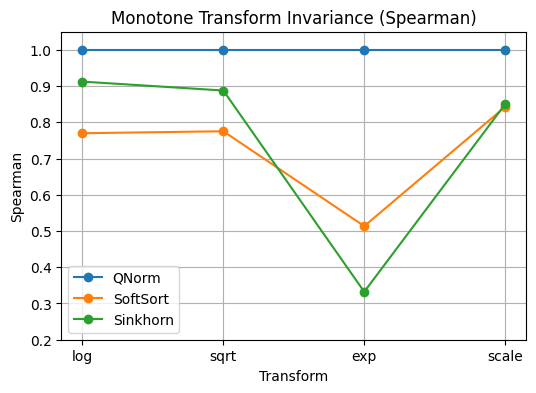

In [ ]:
# ============================================================
# Section 6.1: Rank-level monotone invariance (C1)
# ============================================================

print("========== Rank-level monotone invariance ==========")

N = 2000
x = torch.randn(N)

mu = x.mean()
sigma = x.std() + 1e-6

q_ref = qnorm(x, mu, sigma)
ss_ref = softsort(x)
sk_ref = sinkhorn(x)

tests = [("log", T_log), ("sqrt", T_sqrt), ("exp", T_exp), ("scale", T_scale)]

names, q_vals, s_vals, sk_vals = [], [], [], []

for name, T in tests:
    xt = T(x)
    qv = spearman(q_ref, qnorm(xt, mu, sigma))
    sv = spearman(ss_ref, softsort(xt))
    skv = spearman(sk_ref, sinkhorn(xt))

    print(f"{name:6s}  QNorm={qv:.3f}  Soft={sv:.3f}  Sink={skv:.3f}")

    names.append(name)
    q_vals.append(qv)
    s_vals.append(sv)
    sk_vals.append(skv)

plt.figure(figsize=(6,4))
plt.plot(names, q_vals, marker='o', label="QNorm")
plt.plot(names, s_vals, marker='o', label="SoftSort")
plt.plot(names, sk_vals, marker='o', label="Sinkhorn")
plt.ylim(0.2, 1.05)
plt.title("Monotone Transform Invariance (Spearman)")
plt.xlabel("Transform")
plt.ylabel("Spearman")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ============================================================
# Section 6.1: Batch independence (C2)
# ============================================================

print("\n========== Batch Independence ==========")

population = torch.randn(8000)
x0 = population[123]

mu = population.mean()
sigma = population.std() + 1e-6

vals_q, vals_s, vals_k = [], [], []

for _ in range(200):
    batch = population[torch.randint(0, len(population), (256,))]
    idx = (batch == x0).nonzero(as_tuple=True)
    if len(idx[0]) > 0:
        i = idx[0][0]
        vals_q.append(qnorm(batch, mu, sigma)[i].item())
        vals_s.append(softsort(batch)[i].item())
        vals_k.append(sinkhorn(batch)[i].item())

print(f"QNorm var:   {np.var(vals_q):.3g}")
print(f"SoftSort var:{np.var(vals_s):.3g}")
print(f"Sinkhorn var:{np.var(vals_k):.3g}")


========== Batch Independence ==========
QNorm var:   0
SoftSort var:0.0172
Sinkhorn var:0.0353


In [ ]:
# ============================================================
# Section 6.1: Lipschitz and gradient stability (C3)
# ============================================================

def cdf_smooth(x, ref):
    ref_sorted = ref.sort().values
    idx = torch.searchsorted(ref_sorted, x).float()
    return (idx + 0.5) / len(ref)

def qnorm_smooth(x, ref):
    return torch.sigmoid(cdf_smooth(x, ref))

print("\n========== Lipschitz & Gradient Stability ==========")

population = torch.randn(20000)
x = population[torch.randint(0, len(population), (6000,))]

eps = 1e-3

Q1 = qnorm_smooth(x, population)
Q2 = qnorm_smooth(x + eps, population)

r1 = cdf_smooth(x, population)
r2 = cdf_smooth(x + eps, population)

dr = (r2 - r1).abs()
dQ = (Q2 - Q1).abs()

mask = dr > 0
lip = dQ[mask] / dr[mask]

h = 1e-3
grad = (qnorm_smooth(x + h, population) - qnorm_smooth(x - h, population)) / (2 * h)

print(f"Lipschitz range: {float(lip.min()):.4f} ~ {float(lip.max()):.4f}")
print(f"Gradient range:  {float(grad.min()):.4f} ~ {float(grad.max()):.4f}")


========== Lipschitz & Gradient Stability ==========
Lipschitz range: 0.1955 ~ 0.2515
Gradient range:  0.0049 ~ 0.1700


## 6.2 Model-Level Robustness
This section examines how input normalization satisfying (C1)–(C3) affects model‐level ranking behavior under distribution shifts, in contrast to value‐gap–based alternatives.


=============== Absolute Ranking Performance ===============
shift | QNorm(NDCG,Sp) | SoftSort | Sinkhorn
orig  | (0.966,0.662) | (0.834,0.314) | (0.814,0.196)
scale | (0.971,0.635) | (0.776,0.177) | (0.788,0.136)
shift | (0.941,0.622) | (0.834,0.314) | (0.814,0.196)
warp  | (0.950,0.640) | (0.909,0.440) | (0.795,0.327)


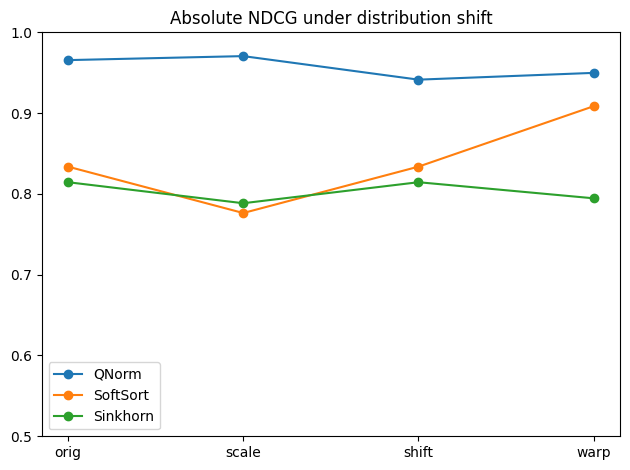

In [ ]:
# ============================================================
# Section 6.2: Model-level distribution-shift stability
# ============================================================

N, d = 1000, 6
X = torch.randn(N, d)

mu = X.mean(dim=0)
sigma = X.std(dim=0) + 1e-6

w = torch.randn(d)
z = X @ w
rnk = torch.sigmoid(z)
noise = 0.1 * torch.randn(N)

y = 0.5 * torch.sigmoid(z) + 0.2 * torch.sin(z) + 0.2 * rnk + 0.1 * noise
y = y.unsqueeze(1)

def q_mlp(x, f1, f2, mu, sigma):
    r = qnorm(x, mu, sigma)
    return f2(torch.relu(f1(r))).squeeze()

def s_mlp(x, f1, f2):
    r = torch.stack([softsort(x[:, j]) for j in range(d)], dim=1)
    return f2(torch.relu(f1(r))).squeeze()

def k_mlp(x, f1, f2):
    r = torch.stack([sinkhorn(x[:, j]) for j in range(d)], dim=1)
    return f2(torch.relu(f1(r))).squeeze()

def init_models():
    f1q = torch.nn.Linear(d, 16); f2q = torch.nn.Linear(16, 1)
    f1s = torch.nn.Linear(d, 16); f2s = torch.nn.Linear(16, 1)
    f1k = torch.nn.Linear(d, 16); f2k = torch.nn.Linear(16, 1)

    torch.nn.init.xavier_uniform_(f1q.weight); torch.nn.init.zeros_(f1q.bias)
    torch.nn.init.xavier_uniform_(f2q.weight); torch.nn.init.zeros_(f2q.bias)

    return f1q, f2q, f1s, f2s, f1k, f2k

def train_models(models):
    f1q, f2q, f1s, f2s, f1k, f2k = models

    opt_q = torch.optim.Adam(list(f1q.parameters()) + list(f2q.parameters()), lr=0.003)
    opt_s = torch.optim.Adam(list(f1s.parameters()) + list(f2s.parameters()), lr=0.003)
    opt_k = torch.optim.Adam(list(f1k.parameters()) + list(f2k.parameters()), lr=0.003)

    for _ in range(50):
        opt_q.zero_grad()
        pred_q = q_mlp(X, f1q, f2q, mu, sigma).unsqueeze(1)
        loss_q = ((pred_q - y)**2).mean()
        loss_q.backward()
        opt_q.step()

        opt_s.zero_grad()
        pred_s = s_mlp(X, f1s, f2s).unsqueeze(1)
        loss_s = ((pred_s - y)**2).mean()
        loss_s.backward()
        opt_s.step()

        opt_k.zero_grad()
        pred_k = k_mlp(X, f1k, f2k).unsqueeze(1)
        loss_k = ((pred_k - y)**2).mean()
        loss_k.backward()
        opt_k.step()

models = init_models()
train_models(models)
f1q, f2q, f1s, f2s, f1k, f2k = models

MQ = lambda x: q_mlp(x, f1q, f2q, mu, sigma)
MS = lambda x: s_mlp(x, f1s, f2s)
MK = lambda x: k_mlp(x, f1k, f2k)

def ndcg(y_true, y_pred, k=50):
    idx = y_pred.argsort(descending=True)
    rel = y_true[idx][:k]
    ideal = rel.sort(descending=True).values
    dcg = (rel / torch.log2(torch.arange(k).float()+2)).sum()
    idcg = (ideal / torch.log2(torch.arange(k).float()+2)).sum()
    return float(dcg/idcg) if idcg > 0 else 0.0

trans_eval = [
    ("orig",  lambda x: x),
    ("scale", T_scale),
    ("shift", T_shift),
    ("warp",  T_tanh),
]

print("\n=============== Absolute Ranking Performance ===============")
print("shift | QNorm(NDCG,Sp) | SoftSort | Sinkhorn")

ndcg_res = []

for name, T in trans_eval:
    XT = apply_featurewise(X, T)
    yq, ys, yk = MQ(XT), MS(XT), MK(XT)
    qn, qsp = ndcg(y.squeeze(), yq), spearman(yq, y.squeeze())
    ss, ssp = ndcg(y.squeeze(), ys), spearman(ys, y.squeeze())
    sk, skp = ndcg(y.squeeze(), yk), spearman(yk, y.squeeze())
    ndcg_res.append((qn, ss, sk))
    print(f"{name:6s}| ({qn:.3f},{qsp:.3f}) | ({ss:.3f},{ssp:.3f}) | ({sk:.3f},{skp:.3f})")

labels = [t[0] for t in trans_eval]
qn_curve = [r[0] for r in ndcg_res]
ss_curve = [r[1] for r in ndcg_res]
sk_curve = [r[2] for r in ndcg_res]

plt.figure()
plt.plot(labels, qn_curve, marker="o")
plt.plot(labels, ss_curve, marker="o")
plt.plot(labels, sk_curve, marker="o")
plt.ylim(0.5, 1.0)
plt.title("Absolute NDCG under distribution shift")
plt.legend(["QNorm", "SoftSort", "Sinkhorn"])
plt.tight_layout()
plt.show()

## 6.3 Real-World Consistency
This section evaluates whether rank‐based input normalization satisfying the proposed structural conditions remains stable on real‐world regression datasets with noise and scale variability.

In [ ]:
# Download NYC Taxi dataset
!wget -q -O taxi.csv https://raw.githubusercontent.com/mwaskom/seaborn-data/master/taxis.csv
print('taxi.csv ready')

taxi.csv ready


In [ ]:
# ============================================================
# Section 6.3: UCI Energy Efficiency experiment
# ============================================================

print("\n========== QNorm-MLP on UCI Energy Efficiency ==========")

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url)

X_np = df.iloc[:, :8].values
y_np = df.iloc[:, 8].values

X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32)

y = (y - y.mean()) / y.std()

scaler = StandardScaler()
X = torch.tensor(scaler.fit_transform(X), dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

mu = X_train.mean(dim=0)
sigma = X_train.std(dim=0) + 1e-6

model = QNormMLP(X.shape[1], mu, sigma)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)

for epoch in range(400):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = ((pred - y_train)**2).mean()
    loss.backward()
    optimizer.step()

with torch.no_grad():
    pred_train = model(X_train)
    pred_test  = model(X_test)

print(f"Train MSE      : {float(((pred_train - y_train)**2).mean()):.4f}")
print(f"Test MSE       : {float(((pred_test - y_test )**2).mean()):.4f}")
print(f"Train Spearman : {spearman(pred_train, y_train):.4f}")
print(f"Test  Spearman : {spearman(pred_test,  y_test):.4f}")


========== QNorm-MLP on UCI Energy Efficiency ==========
Train MSE      : 0.0061
Test MSE       : 0.0080
Train Spearman : 0.9937
Test  Spearman : 0.9914


In [ ]:
# ============================================================
# Section 6.3: California Housing experiment
# ============================================================

print("\n========== QNorm-MLP on California Housing ==========")

cal = fetch_california_housing()
X_np = cal.data
y_np = cal.target

X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32)
y = (y - y.mean()) / y.std()

scaler = StandardScaler()
X = torch.tensor(scaler.fit_transform(X), dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

mu = X_train.mean(dim=0)
sigma = X_train.std(dim=0) + 1e-6

model = QNormMLP(X.shape[1], mu, sigma)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)

for epoch in range(400):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = ((pred - y_train)**2).mean()
    loss.backward()
    optimizer.step()

with torch.no_grad():
    pred_train = model(X_train)
    pred_test  = model(X_test)

print(f"Train MSE      : {float(((pred_train - y_train)**2).mean()):.4f}")
print(f"Test MSE       : {float(((pred_test - y_test )**2).mean()):.4f}")
print(f"Train Spearman : {spearman(pred_train, y_train):.4f}")
print(f"Test  Spearman : {spearman(pred_test,  y_test):.4f}")


========== QNorm-MLP on California Housing ==========
Train MSE      : 0.2414
Test MSE       : 0.2494
Train Spearman : 0.8757
Test  Spearman : 0.8676


In [ ]:
# ============================================================
# Section 6.3: NYC Taxi Trip Duration experiment
# ============================================================

print("\n========== QNorm-MLP on NYC Taxi Trip Duration ==========")

df = pd.read_csv("taxi.csv")
df['pickup']  = pd.to_datetime(df['pickup'])
df['dropoff'] = pd.to_datetime(df['dropoff'])
df['trip_time'] = (df['dropoff'] - df['pickup']).dt.total_seconds()
df = df.dropna()
df = df[df['trip_time'] > 0]

feature_cols = ["distance", "fare", "tip", "tolls", "passengers"]
X_np = df[feature_cols].values
y_np = df["trip_time"].values

X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor((y_np - y_np.mean()) / y_np.std(), dtype=torch.float32)

scaler = StandardScaler()
X = torch.tensor(scaler.fit_transform(X), dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

mu = X_train.mean(dim=0)
sigma = X_train.std(dim=0) + 1e-6

model = QNormMLP(X.shape[1], mu, sigma)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)

for epoch in range(400):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = ((pred - y_train)**2).mean()
    loss.backward()
    optimizer.step()

with torch.no_grad():
    pred_train = model(X_train)
    pred_test  = model(X_test)

print(f"Train MSE      : {float(((pred_train - y_train)**2).mean()):.4f}")
print(f"Test MSE       : {float(((pred_test - y_test )**2).mean()):.4f}")
print(f"Train Spearman : {spearman(pred_train, y_train):.4f}")
print(f"Test  Spearman : {spearman(pred_test,  y_test):.4f}")


========== QNorm-MLP on NYC Taxi Trip Duration ==========
Train MSE      : 0.0820
Test MSE       : 0.0926
Train Spearman : 0.9863
Test  Spearman : 0.9833
